In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [86]:
df = pd.read_csv('/Users/kushagragahlaut/Desktop/code/AirPassengers.csv')
print(df.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


In [119]:
df.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [87]:
dateparse = lambda dates : pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('/Users/kushagragahlaut/Desktop/code/AirPassengers.csv', parse_dates=['Month'],
                index_col = 'Month', date_parser= dateparse)
df.head()


# OR  df['Month']= pd.to_datetime(df['Month'])

/Users/kushagragahlaut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [88]:
df.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [89]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

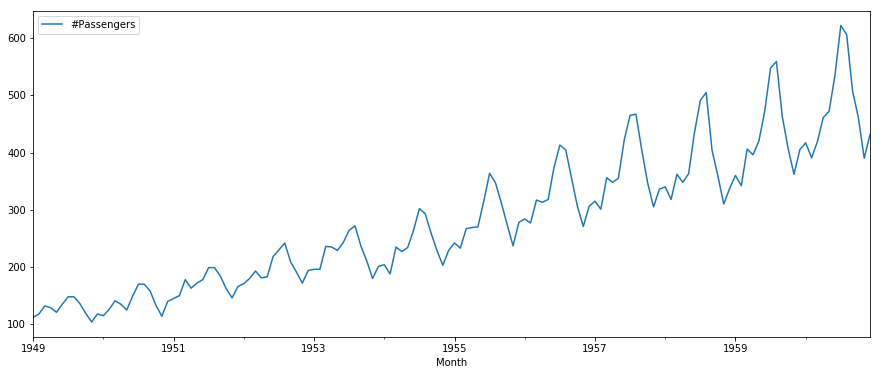

In [122]:
df.plot()

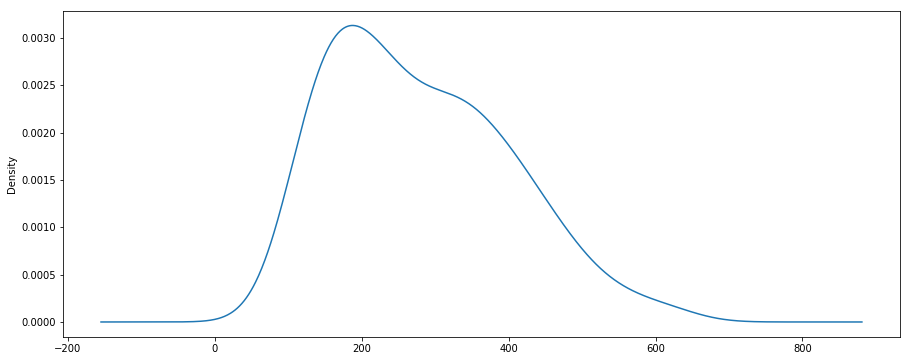

In [90]:
ts= df['#Passengers']
#ts.head()
ts.plot(kind ='kde')

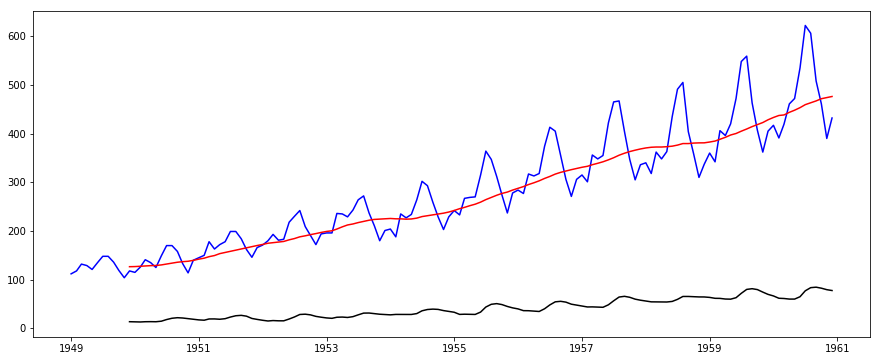

Test Statistics             0.815369
p-value                     0.991880
No. of lags used           13.000000
Number of observations    130.000000
critical value (1%)        -3.481682
critical value (5%)        -2.884042
critical value (10%)       -2.578770
dtype: float64

Failed to reject the null Hypothesis since p-value > 0.05. Time series is not stationary


In [166]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics of this data
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plotting rolling statistics
    plt.plot(timeseries,color='blue',label='Original')
    #plt.show(block=False)
    
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling STD')
    plt.show(block=False)

    adft = adfuller(timeseries,autolag='AIC')

    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)
    
    if adft[1] > 0.05:
        print(f"\nFailed to reject the null Hypothesis since {'p-value'} > 0.05. Time series is not stationary")
    else:
        print('Time series is stationary')
        
        # Additional condition when adft[1] <= 0.05
        if output["critical value (1%)"] > adft[0]:
            print('99% sure that data is stationary')
        elif output["critical value (5%)"] > adft[0]:
            print('95% sure that data is stationary')    

test_stationarity(ts)

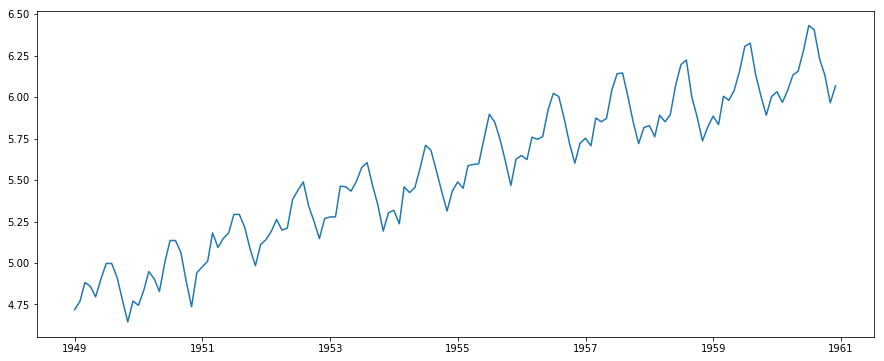

In [92]:
#MAKING TS STATIONARY

ts_log = np.log(ts)
plt.plot(ts_log)



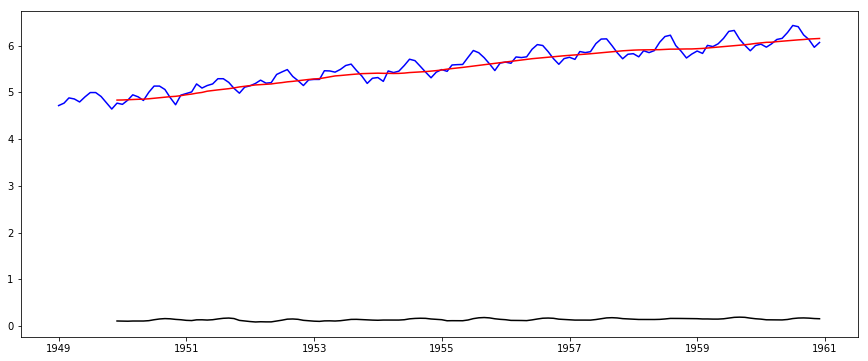

Test Statistics            -1.717017
p-value                     0.422367
No. of lags used           13.000000
Number of observations    130.000000
critical value (1%)        -3.481682
critical value (5%)        -2.884042
critical value (10%)       -2.578770
dtype: float64

Failed to reject the null Hypothesis since p-value > 0.05. Time series is not stationary


In [159]:
test_stationarity(ts_log)


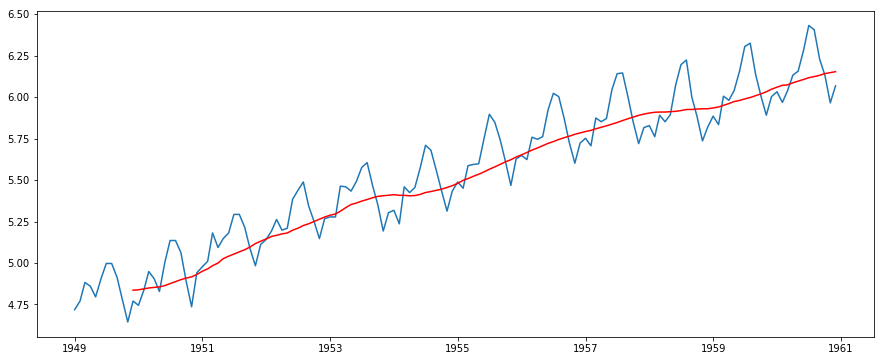

In [160]:
#Smoothing
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [161]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(5)

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: #Passengers, dtype: float64

In [162]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head(5)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

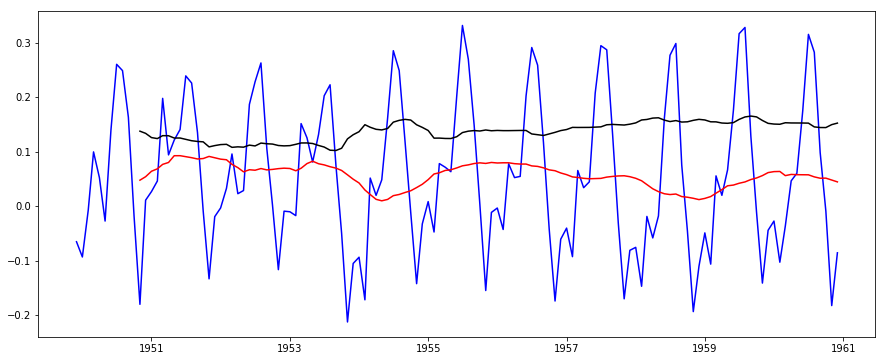

Test Statistics            -3.162908
p-value                     0.022235
No. of lags used           13.000000
Number of observations    119.000000
critical value (1%)        -3.486535
critical value (5%)        -2.886151
critical value (10%)       -2.579896
dtype: float64
Time series is stationary
95% sure that data is stationary


In [167]:
#TEST STATIONARITY AGAIN
test_stationarity(ts_log_moving_avg_diff)

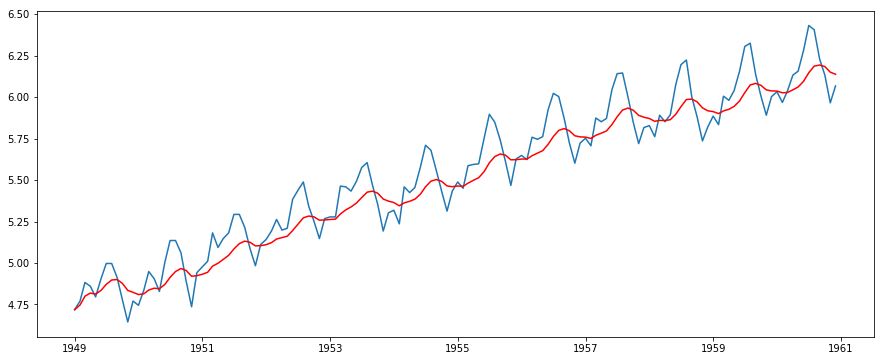

In [98]:
#another method to check for stationary... hoping to get better results than prev
expwighted_avg = ts_log.ewm(span=12).mean() 
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

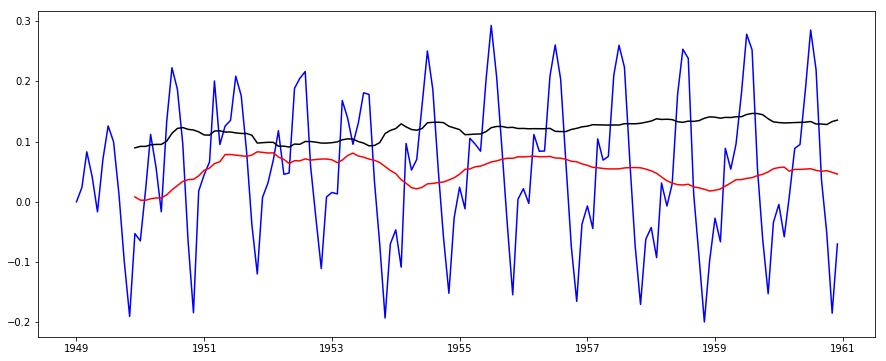

Test Statistics            -3.310542
p-value                     0.014414
No. of lags used           13.000000
Number of observations    130.000000
critical value (1%)        -3.481682
critical value (5%)        -2.884042
critical value (10%)       -2.578770
dtype: float64
Time series is stationary
95% sure that data is stationary


In [168]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

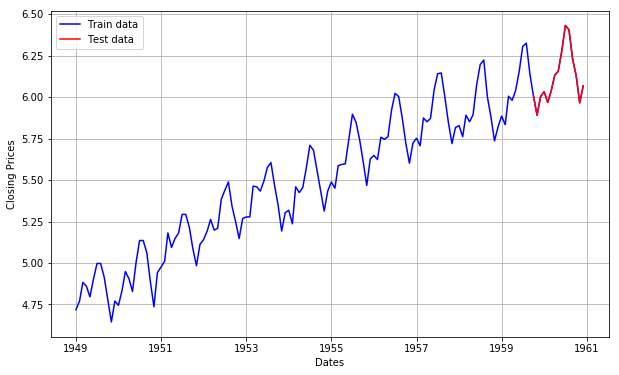

In [100]:
ts_log = np.log(ts)
train_data, test_data = df_log[3:int(len(df_log)*0.9)],df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log,'blue',label='Train data')
plt.plot(test_data,'red',label='Test data')
plt.legend()

<Figure size 1080x432 with 0 Axes>

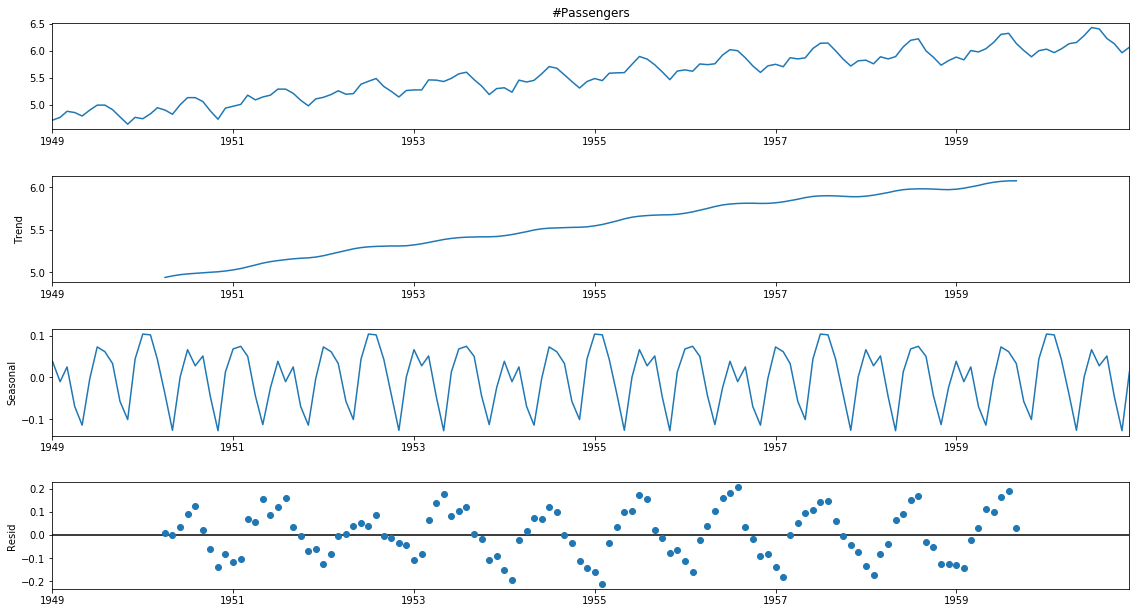

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts_log, model='additive',period=30)
fig = plt.figure()
fig = result.plot()
#fig.set_size_inches(16, 9)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-197.759, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=789.464, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-202.099, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-200.307, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-200.547, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-206.861, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-203.235, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-201.597, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-205.006, Time=0.35 se

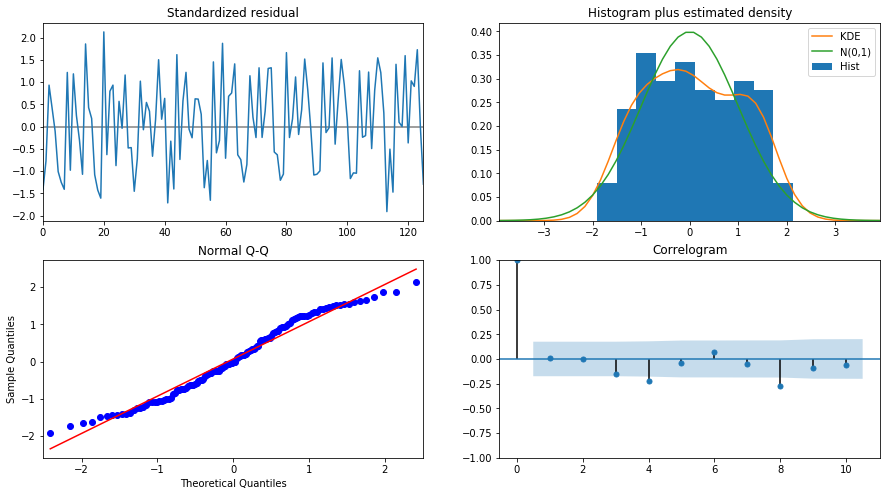

In [115]:
#PACF 
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=4, max_q=4, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [116]:
# Building the model
import statsmodels.api as sm
order = model_autoARIMA.order

model = sm.tsa.ARIMA(train_data, order=order)
fitted = model.fit()
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:            #Passengers   No. Observations:                  126
Model:                     ARMA(2, 1)   Log Likelihood                 108.431
Method:                       css-mle   S.D. of innovations              0.101
Date:                Wed, 03 Jan 2024   AIC                           -206.861
Time:                        14:48:06   BIC                           -192.680
Sample:                    04-01-1949   HQIC                          -201.100
                         - 09-01-1959                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.4970      0.249     22.037      0.000       5.008       5.986
ar.L1.#Passengers     0.3684      0.130      2.835      0.005       0.114       0.623
ar.L2.#Passengers     0.

/Users/kushagragahlaut/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/kushagragahlaut/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was p

In [117]:
# Forecast
forecast_steps = len(test_data)  # Adjust the number of steps as needed

# Use forecast method on the fitted model
forecast, stderr, conf_int = fitted.forecast(steps=forecast_steps, alpha=0.05)

# Create a summary frame for the forecast
result = pd.DataFrame({'mean': forecast, 'mean_ci_lower': conf_int[:, 0], 'mean_ci_upper': conf_int[:, 1]})

# Print the result
print(result)

        mean  mean_ci_lower  mean_ci_upper
0   6.097151       5.899226       6.295076
1   6.086799       5.772358       6.401239
2   6.059636       5.684867       6.434404
3   6.043671       5.611252       6.476091
4   6.022159       5.547058       6.497260
5   6.005048       5.490861       6.519235
6   5.986365       5.439673       6.533056
7   5.969635       5.393581       6.545688
8   5.952721       5.351035       6.554406
9   5.936862       5.312030       6.561694
10  5.921287       5.275782       6.566792
11  5.906423       5.242180       6.570666
12  5.891985       5.210802       6.573167
13  5.878112       5.181508       6.574716
14  5.864693       5.154047       6.575339


In [118]:
#transforming log to exp
prediction = result['mean']
predicted_passengers = np.exp(prediction)
print(predicted_passengers)


0     444.589367
1     440.010496
2     428.219354
3     421.437417
4     412.468250
5     405.470267
6     397.965202
7     391.362747
8     384.798796
9     378.744677
10    372.891255
11    367.389731
12    362.123243
13    357.134404
14    352.373937
Name: mean, dtype: float64


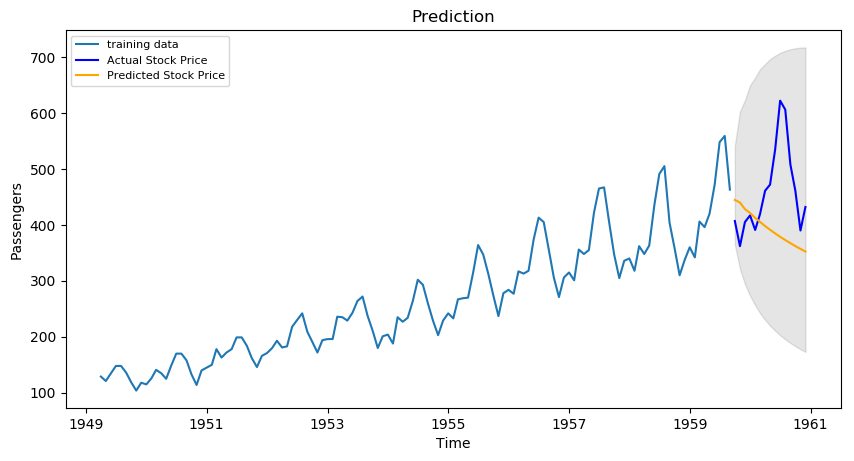

In [114]:
fc_series = pd.Series(np.exp(result['mean']).values, index=test_data.index)
lower_series = pd.Series(np.exp(result['mean_ci_lower']).values, index=test_data.index)
upper_series = pd.Series(np.exp(result['mean_ci_upper']).values, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
color='k', alpha=.10)
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend(loc='upper left', fontsize=8)
plt.show()

       
      ----------X------------

### ARIMA (aLSO can be done like this)

In [126]:
## Use Techniques Differencing
df['Passengers First Difference']=df['#Passengers']-df['#Passengers'].shift(1)

In [127]:
# Use Techniques Differencing
df['Passengers Second Difference']=df['Passengers First Difference']-df['Passengers First Difference'].shift(1)

In [128]:
## Use Techniques Differencing
df['Passengers Second Difference']=df['Passengers First Difference']-df['Passengers First Difference'].shift(1)

In [129]:
### 12 months 
## Use Techniques Differencing
df['Passengers 12 Difference']=df['#Passengers']-df['#Passengers'].shift(12)

In [130]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

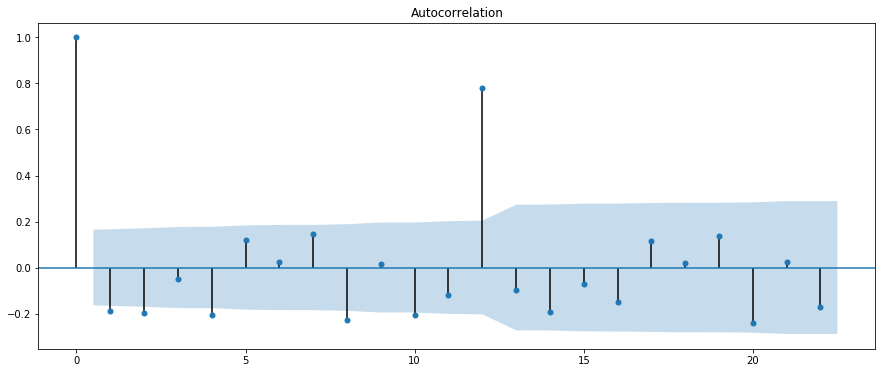

In [131]:
acf = plot_acf(df["Passengers Second Difference"].dropna())

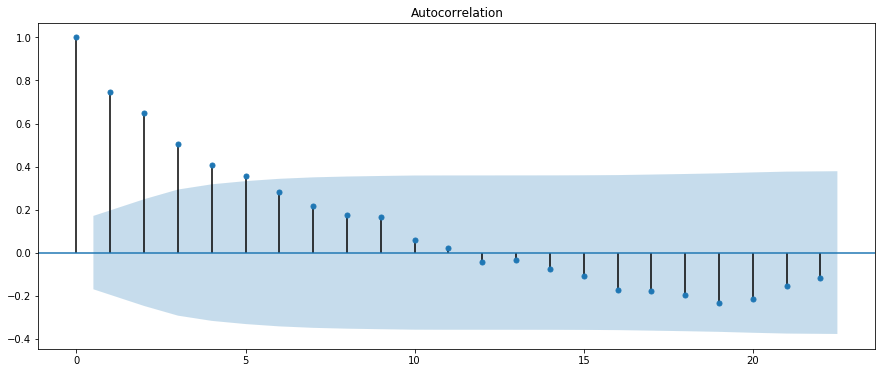

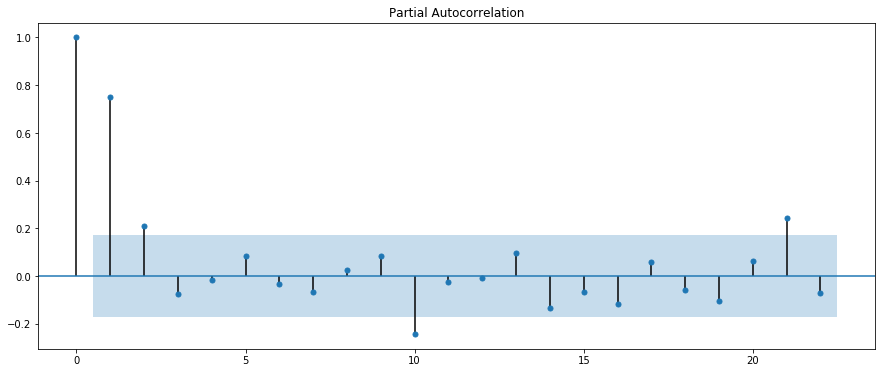

In [132]:
acf12 = plot_acf(df["Passengers 12 Difference"].dropna())
pacf12 = plot_pacf(df["Passengers 12 Difference"].dropna())

/Users/kushagragahlaut/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


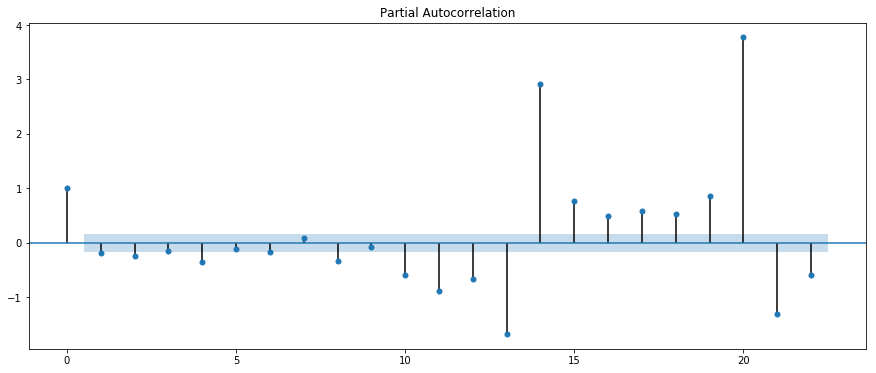

In [133]:
result = plot_pacf(df["Passengers Second Difference"].dropna())


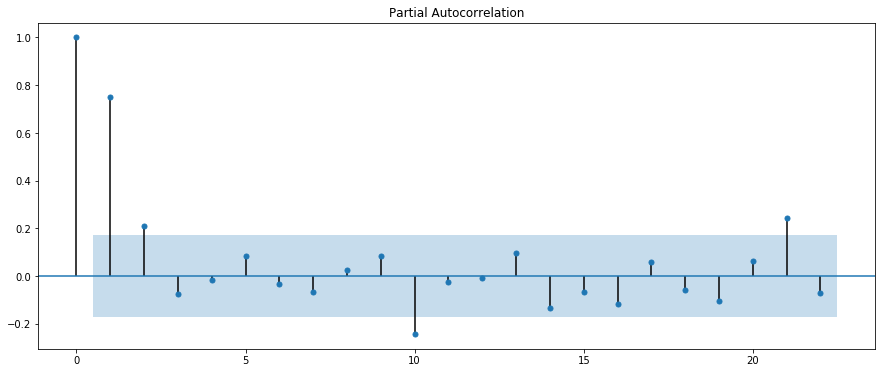

In [134]:
pacf12 = plot_pacf(df["Passengers 12 Difference"].dropna())


In [136]:
from datetime import datetime,timedelta

train_dataset_end=datetime(1955,12,1)
test_dataset_end=datetime(1960,12,1)

train_data=df[:train_dataset_end]
test_data=df[train_dataset_end+timedelta(days=1):test_dataset_end]

##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

test_data

,#Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1956-01-01,284,6.0,-35.0,42.0
1956-02-01,277,-7.0,-13.0,44.0
1956-03-01,317,40.0,47.0,50.0
1956-04-01,313,-4.0,-44.0,44.0
1956-05-01,318,5.0,9.0,48.0
1956-06-01,374,56.0,51.0,59.0
1956-07-01,413,39.0,-17.0,49.0
1956-08-01,405,-8.0,-47.0,58.0
1956-09-01,355,-50.0,-42.0,43.0


In [137]:
## create a ARIMA model
from statsmodels.tsa.arima_model import ARIMA

train_data

,#Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN
...,...,...,...,...
1955-08-01,347,-17.0,-66.0,54.0
1955-09-01,312,-35.0,-18.0,53.0
1955-10-01,274,-38.0,-3.0,45.0


In [139]:
model_ARIMA=ARIMA(train_data['#Passengers'],order=(0,2,0))


/Users/kushagragahlaut/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/kushagragahlaut/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was p

In [140]:
model_Arima_fit=model_ARIMA.fit()
model_Arima_fit.summary()

/Users/kushagragahlaut/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D2.#Passengers   No. Observations:                   82
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -385.782
Method:                           css   S.D. of innovations             26.728
Date:                Tue, 16 Jan 2024   AIC                            775.563
Time:                        18:47:09   BIC                            780.377
Sample:                    03-01-1949   HQIC                           777.496
                         - 12-01-1955                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4268      2.952      0.145      0.885      -5.358       6.212
==============================================================================
"""

In [141]:
test_data

,#Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1956-01-01,284,6.0,-35.0,42.0
1956-02-01,277,-7.0,-13.0,44.0
1956-03-01,317,40.0,47.0,50.0
1956-04-01,313,-4.0,-44.0,44.0
1956-05-01,318,5.0,9.0,48.0
1956-06-01,374,56.0,51.0,59.0
1956-07-01,413,39.0,-17.0,49.0
1956-08-01,405,-8.0,-47.0,58.0
1956-09-01,355,-50.0,-42.0,43.0


In [143]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

print(pred_start_date)

print(pred_end_date)
# 1956-01-01 00:00:00
# 1960-12-01 00:00:00
        
pred=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['#Passengers']-pred

1956-01-01 00:00:00
1960-12-01 00:00:00


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

# FbProphet

In [121]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'